In [1]:
import pandas as pd
import polars as pl
import numpy as np
np.random.seed(2025)
import typing as t
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm.notebook import tqdm
from IPython.display import HTML
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import warnings
import pandas as pd
import numpy as np
import hnswlib
from typing import Optional, List, Tuple
from sklearn.preprocessing import StandardScaler


data_folder = "/home/gleb_galagan/tbank_recsys/sirius_recsys/sirius-2025-recsys/data/"
train = pl.read_parquet(data_folder + "train.pq")
books = pl.read_parquet('/home/gleb_galagan/tbank_recsys/baseline_solution/books_all_embs.parquet')
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))

In [2]:
n_books = books.shape[0]
print(f"N books: {n_books}")

n_cold_books = n_books - train["item_id"].n_unique()
print(f"N 'cold' books: {n_cold_books}")
all_books = set(books['item_id']) 
train_books = set(train['item_id'])
cold_books = all_books - train_books
hot_books = all_books & train_books


N books: 34322
N 'cold' books: 3022


In [3]:
# ACHTUNG! DO NOT TOUCH

@dataclass
class AtKMetric(ABC):
    k: int

    @property
    @abstractmethod
    def name(self) -> str:
        raise NotImplementedError

    @property
    def full_name(self) -> str:
        return f"{self.name}@{self.k}"

    @abstractmethod
    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        raise NotImplementedError


class NDCG(AtKMetric):
    @property
    def name(self) -> str:
        return "ndcg"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def _dcg(scores: np.ndarray) -> float:
            # Handle empty arrays
            if len(scores) == 0:
                return 0.0
            # Use vectorized operations for better performance
            positions = np.arange(1, len(scores) + 1, dtype=np.float64)
            return np.sum((np.power(2, scores) - 1) / np.log2(positions + 1))

        def ndcg(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty predictions or ground truth
            if not predicted or not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Create relevance scores (1 for relevant items, 0 otherwise)
            relevance = np.array([1 if x in gt_items else 0 for x in predicted], dtype=np.float64)
            
            rank_dcg = _dcg(relevance)
            if rank_dcg == 0.0:
                return 0.0
                
            # Ideal DCG: sort ground truth by relevance (all 1s) and take top-k
            ideal_relevance = np.ones(min(len(gt_items), self.k), dtype=np.float64)
            ideal_dcg = _dcg(ideal_relevance)
            
            if ideal_dcg == 0.0:
                return 0.0
                
            return rank_dcg / ideal_dcg

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: ndcg(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


class Recall(AtKMetric):
    @property
    def name(self) -> str:
        return "recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty ground truth
            if not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Calculate intersection
            intersection = len(set(gt_items).intersection(set(predicted)))
            return intersection / len(gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)

# ==================
# Новая метрика ARP
# ==================
class ARP(AtKMetric):
    """
    Calculates the Average Recommendation Popularity (ARP).
    This metric measures the average popularity of the recommended items.
    A lower ARP suggests the model is recommending less obvious, "long-tail" items.
    """
    @property
    def name(self) -> str:
        return "arp"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for ARP metric")

        def arp(predicted: list[t.Any]) -> float:
            if isinstance(predicted, pl.Series):
                predicted = predicted.to_list()
            if not predicted:
                return 0.0
            
            predicted = predicted[:self.k]
            
            # Get popularities, default to 0 if item not in map
            popularities = [item_popularity_map.get(item, 0.0) for item in predicted]
            
            if not popularities:
                return 0.0
                
            return sum(popularities) / len(popularities)

        # Note: ground_truth_col is not used but is part of the abstract method signature.
        return pl.col(preds_col).map_elements(
            lambda p: arp(p),
            return_dtype=pl.Float64
        ).alias(self.full_name)
        
# ==============
# Новая метрика Serndipity
# ==============
class Serendipity(AtKMetric):
    """
    Calculates Serendipity.
    This metric rewards recommendations that are both relevant (in ground truth)
    and surprising (unpopular). The score for a user is the sum of (1 - popularity)
    for each correctly recommended item.
    """
    @property
    def name(self) -> str:
        return "serendipity"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for Serendipity metric")

        def serendipity(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            if not predicted or not gt_items:
                return 0.0
                
            predicted = predicted[:self.k]
            
            # Find relevant recommended items
            relevant_preds = set(predicted).intersection(set(gt_items))
            
            if not relevant_preds:
                return 0.0
                
            # Score is the sum of (1 - popularity) for each relevant item
            score = sum(1 - item_popularity_map.get(item, 0.0) for item in relevant_preds)
            
            # Normalize by k to get an average serendipity score per recommendation slot
            return score / self.k

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: serendipity(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)



def coverage(df: pl.DataFrame, n_items_in_catalog: int, preds_col: str = "preds") -> float:
    if n_items_in_catalog <= 0:
        return 0.0
        
    unique_recommended = df.select(
        pl.col(preds_col).explode().n_unique()
    ).item()
    return unique_recommended / n_items_in_catalog



def evaluate_extended(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    n_items_in_catalog: int = n_books,
    k: int = 10,
    train_df: pl.DataFrame | None = train,
) -> dict:
    """
    Расширенная функция расчета метрик. Здесь добавлены ARP и Serendipity. Для расчета этих метрик считаем матрицу популярности. 
    """
    # Compute item_popularity_map from train_df
    if train_df is not None:
        total_interactions = train_df.height
        item_counts = (
            train_df
            .group_by("item_id")
            .agg(pl.count().alias("count"))
        )
    
    # Normalize by maximum count to get 0-1 range
        max_count = item_counts.select(pl.col("count").max()).item()
    
        item_popularity_map = dict(
            item_counts
            .with_columns((pl.col("count") / max_count).alias("popularity"))
            .select(["item_id", "popularity"])
            .iter_rows()
        )
    else:
        item_popularity_map = None

    metrics = [
        NDCG(k=k),
        Recall(k=k),
    ]

    if item_popularity_map:
        metrics.extend([
            ARP(k=k),
            Serendipity(k=k),
        ])

    result = {}
    result_df = df.clone()

    for metric in metrics:
        metric_kwargs = {
            "preds_col": model_preds_col,
            "ground_truth_col": ground_truth_col,
        }
        if isinstance(metric, (ARP, Serendipity)):
            if not item_popularity_map:
                print(f"Skipping {metric.name} because item_popularity_map is not provided.")
                continue
            metric_kwargs["item_popularity_map"] = item_popularity_map

        # Calculate metric
        result_df = result_df.with_columns(
            metric(**metric_kwargs)
        )
        
        result[metric.full_name] = round(result_df.select(pl.col(metric.full_name).mean()).item(), 3)

    if n_items_in_catalog is not None:
        result["coverage"] = round(coverage(result_df, n_items_in_catalog, preds_col=model_preds_col), 3)

    return result


In [4]:
def evaluate_cold_item_performance(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    cold_items: set[int] = cold_books,
    k: int = 10,
) -> dict:
    """
    Evaluates model performance specifically on cold vs warm items.
    For each user, splits their ground truth into cold/warm and measures
    how many cold items vs warm items the model successfully recommends.
    """
    
    def split_ground_truth_and_calculate_metrics(predicted: list, gt_items: list) -> dict:
        if not predicted or not gt_items:
            return {"cold_hits": 0, "warm_hits": 0, "total_cold_gt": 0, "total_warm_gt": 0}
        
        predicted_top_k = predicted[:k]
        predicted_set = set(predicted_top_k)
        
        # Split ground truth into cold and warm
        cold_gt = [item for item in gt_items if item in cold_items]
        warm_gt = [item for item in gt_items if item not in cold_items]
        
        cold_hits = len([item for item in cold_gt if item in predicted_set])
        warm_hits = len([item for item in warm_gt if item in predicted_set])
        
        return {
            "cold_hits": cold_hits,
            "warm_hits": warm_hits,
            "total_cold_gt": len(cold_gt),
            "total_warm_gt": len(warm_gt)
        }
    
    results = []
    for row in df.iter_rows(named=True):
        predicted = row[model_preds_col]
        gt_items = row[ground_truth_col]
        results.append(split_ground_truth_and_calculate_metrics(predicted, gt_items))
    
    # Аггрегируем результаты
    total_cold_hits = sum(r["cold_hits"] for r in results)
    total_warm_hits = sum(r["warm_hits"] for r in results)
    total_cold_gt = sum(r["total_cold_gt"] for r in results)
    total_warm_gt = sum(r["total_warm_gt"] for r in results)
    
    metrics = {}
    
    # Cold item recall
    if total_cold_gt > 0:
        metrics["cold_item_recall"] = round(total_cold_hits / total_cold_gt, 3)
    else:
        metrics["cold_item_recall"] = 0.0
    
    # Warm item recall  
    if total_warm_gt > 0:
        metrics["warm_item_recall"] = round(total_warm_hits / total_warm_gt, 3)
    else:
        metrics["warm_item_recall"] = 0.0
    
    # Доп статистика по количеству
    metrics["total_cold_items_in_gt"] = total_cold_gt
    metrics["total_warm_items_in_gt"] = total_warm_gt
    metrics["cold_items_recommended"] = total_cold_hits
    metrics["warm_items_recommended"] = total_warm_hits
    
    return metrics


def evaluate_by_user_types(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    cold_items: set[int] = None,
    k: int = 10,
    train_df: pl.DataFrame | None = train,
) -> dict:
    """
    Evaluates performance by user types:
    - pure_cold: users who have ONLY cold items in ground truth
    - mixed: users who have both cold and warm items
    - pure_warm: users who have ONLY warm items in ground truth
    """
    
    # Классифицируем юзеров на тех у кого есть холодные айтемы и тех у кого нет
    df = df.with_columns([
        # Count cold items in ground truth
        pl.col(ground_truth_col)
        .list.eval(pl.element().is_in(cold_items))
        .list.sum()
        .alias("cold_count"),
        
        # Total items in ground truth
        pl.col(ground_truth_col).list.len().alias("total_count")
    ]).with_columns([
        # Classify user types
        pl.when(pl.col("cold_count") == pl.col("total_count"))
        .then(pl.lit("pure_cold"))
        .when(pl.col("cold_count") == 0)
        .then(pl.lit("pure_warm"))  
        .otherwise(pl.lit("mixed"))
        .alias("user_type")
    ])
    
    metrics = [NDCG(k=k), Recall(k=k)]
    result = {}
    
    # Добавляем ARP и Serendipity
    if train_df is not None:
        item_counts = train_df.group_by("item_id").agg(pl.count().alias("count"))
        max_count = item_counts.select(pl.col("count").max()).item()
        item_popularity_map = dict(
            item_counts
            .with_columns((pl.col("count") / max_count).alias("popularity"))
            .select(["item_id", "popularity"])
            .iter_rows()
        )
        metrics.extend([ARP(k=k), Serendipity(k=k)])
    else:
        item_popularity_map = None
    
    # Evaluate each user type
    for user_type in ["pure_cold", "mixed", "pure_warm"]:
        type_df = df.filter(pl.col("user_type") == user_type)
        
        if type_df.height == 0:
            continue
            
        print(f"\n{user_type}: {type_df.height} users")
        
        for metric in metrics:
            metric_kwargs = {
                "preds_col": model_preds_col,
                "ground_truth_col": ground_truth_col,
            }
            
            if isinstance(metric, (ARP, Serendipity)) and item_popularity_map:
                metric_kwargs["item_popularity_map"] = item_popularity_map
            
            type_df = type_df.with_columns(metric(**metric_kwargs))
            result[f"{metric.full_name}_{user_type}"] = round(
                type_df.select(pl.col(metric.full_name).mean()).item(), 3
            )
    
    return result

In [5]:
all_books = set(books['item_id']) 
train_books = set(train['item_id'])
cold_books = all_books - train_books
hot_books = all_books & train_books


print(f'Hot books {len(hot_books)}\n\nCold books {len(cold_books)}')

Hot books 31300

Cold books 3022


## HNSW Cosine

In [6]:


class ItemHNSWCosine:
    def __init__(self, ef_construction: int = 200, M: int = 16, ef: int = 50):
        """
        Initialize HNSW recommender.
        
        Args:
            ef_construction: Size of dynamic candidate list during construction (higher = better quality, slower build)
            M: Number of bi-directional links for every new element during construction (higher = better recall, more memory)
            ef: Size of dynamic candidate list during search (higher = better accuracy, slower search)
        """
        self.trained: bool = False
        self.train_most_liked_item: pl.DataFrame | None = None
        self.items_embeddings: np.ndarray | None = None
        self.items_item_ids: np.ndarray | None = None
        self.hnsw_index: hnswlib.Index | None = None
        self.ef_construction = ef_construction
        self.M = M
        self.ef = ef

    def fit(
        self,
        df: pl.DataFrame,
        items_df: pl.DataFrame,
        item_id_col: str = "item_id",
        embedding_col: str = "description_embeddings"
    ) -> None:
        
        # Переводим эмбеддинги в float32 для экономии вычислений
        embeddings_list = items_df[embedding_col].to_list()
        self.items_embeddings = np.array(embeddings_list, dtype=np.float32)
        
        # Нормализуем эмбеддинги для расчета косинусного сходства
        norms = np.linalg.norm(self.items_embeddings, axis=1, keepdims=True)
        self.items_embeddings = self.items_embeddings / (norms + 1e-8)
        
        self.items_item_ids = items_df[item_id_col].to_numpy()
        
        # Initialize HNSW index
        dim = self.items_embeddings.shape[1]
        num_items = self.items_embeddings.shape[0]
        
        # Инициализируем индекс HNSW с метрикой inner product - эквивалентно cos
        self.hnsw_index = hnswlib.Index(space='ip', dim=dim)
        self.hnsw_index.init_index(
            max_elements=num_items, 
            ef_construction=self.ef_construction, 
            M=self.M
        )
        
        # Добавляем айтемы в индекс
        self.hnsw_index.add_items(self.items_embeddings, np.arange(num_items))
        self.hnsw_index.set_ef(self.ef)

        # Находим самый залайканный айтем для каждого юзера
        self.train_most_liked_item = (
            df.lazy()
            .sort("rating", descending=True)
            .group_by("user_id")
            .agg(pl.col(item_id_col).first().alias(item_id_col))
            .join(
                items_df.lazy().select([item_id_col, embedding_col]),
                on=item_id_col,
                how="left"
            )
            .collect()
        )
        self.trained = True

    def _get_batch_predictions(
        self,
        batch_user_embeddings: np.ndarray,
        batch_current_items: np.ndarray,
        batch_user_mask: np.ndarray,
        topn: int
    ) -> list[np.ndarray]:
        batch_predictions = []
        
        # Нормализуем эмбеддинги юзеров для расчета косинусного сходства

        norms = np.linalg.norm(batch_user_embeddings, axis=1, keepdims=True)
        batch_user_embeddings_norm = batch_user_embeddings / (norms + 1e-8)

        for user_embedding, current_item, has_embedding in zip(
            batch_user_embeddings_norm, batch_current_items, batch_user_mask
        ):
            if not has_embedding:
                batch_predictions.append([])
                continue

            # Query HNSW index for similar items
            # Находим в индексе HNSW близкие айтемы
            query_k = min(topn + 5, len(self.items_item_ids))
            labels, distances = self.hnsw_index.knn_query(user_embedding, k=query_k)
            
            # Приводим к ID айтемов и фильтруем текущий айтем
            recommended_items = []
            for label in labels[0]:  # labels is 2D array
                item_id = self.items_item_ids[label]
                if item_id != current_item:
                    recommended_items.append(item_id)
                if len(recommended_items) >= topn:
                    break

            batch_predictions.append(recommended_items)

        return batch_predictions

    def predict(
        self,
        df: pl.DataFrame,
        topn: int = 10,
        batch_size: int = 5_000,
        embedding_col: str = "description_embeddings"
    ) -> list[np.ndarray]:
        
        assert self.trained
        
        user_data = (
            df.select(["user_id"])
            .join(self.train_most_liked_item, on="user_id", how="left")
        )

        user_embeddings = np.array(user_data[embedding_col].to_list(), dtype=np.float32)
        current_items = user_data["item_id"].to_numpy()
        user_mask = user_data[embedding_col].is_not_null().to_numpy()

        predictions = []
        n_users = len(user_data)

        for batch_start in tqdm(range(0, n_users, batch_size)):
            batch_end = min(batch_start + batch_size, n_users)
            
            batch_predictions = self._get_batch_predictions(
                user_embeddings[batch_start:batch_end],
                current_items[batch_start:batch_end],
                user_mask[batch_start:batch_end],
                topn
            )
            predictions.extend(batch_predictions)

        return predictions

    def get_similar_items(self, item_id, topn: int = 10) -> list:
        """
        Get similar items to a given item using HNSW.
        """
        assert self.trained
        
        # Find item index
        item_idx = np.where(self.items_item_ids == item_id)[0]
        if len(item_idx) == 0:
            return []
        
        item_idx = item_idx[0]
        item_embedding = self.items_embeddings[item_idx]
        
        # Query HNSW
        labels, distances = self.hnsw_index.knn_query(item_embedding, k=topn + 1)
        
        # Filter out the query item itself
        similar_items = []
        for label in labels[0]:
            if label != item_idx:
                similar_items.append(self.items_item_ids[label])
            if len(similar_items) >= topn:
                break
                
        return similar_items

In [7]:
item_knn_cosine = ItemHNSWCosine(ef_construction=200, M=16, ef=50)
item_knn_cosine.fit(train, books)
test = test.with_columns(
    hnsw_recs=pl.Series(item_knn_cosine.predict(test))
)
print(test.head())
hnsw_dict_ov = {}
hnsw_dict_split = {}
hnsw_dict_perf = {}


hnsw_rec_overall = evaluate_extended(
        df=test,
        model_preds_col="hnsw_recs",
        n_items_in_catalog=n_books,
        k=10,
        train_df=train  
    )
hnsw_rec_split = evaluate_by_user_types(
        df=test,
        model_preds_col="hnsw_recs",
        cold_items=cold_books,
        
    )


hnsw_rec_perf = evaluate_cold_item_performance(df=test,
        model_preds_col="hnsw_recs",
    )


hnsw_dict_ov['hnsw_one'] = hnsw_rec_overall
hnsw_dict_split['hnsw_one'] = hnsw_rec_split
hnsw_dict_perf['hnsw_one'] = hnsw_rec_perf

  0%|          | 0/38 [00:00<?, ?it/s]

shape: (5, 3)
┌─────────────────────────────────┬───────────────────────┬─────────────────────────┐
│ user_id                         ┆ item_id               ┆ hnsw_recs               │
│ ---                             ┆ ---                   ┆ ---                     │
│ str                             ┆ list[i64]             ┆ list[i64]               │
╞═════════════════════════════════╪═══════════════════════╪═════════════════════════╡
│ 00000377eea48021d3002730d56aca… ┆ [13252]               ┆ [12482, 22632, … 19110] │
│ 00009ab2ed8cbfceda5a59da409663… ┆ [2328]                ┆ [20150, 32516, … 3563]  │
│ 00009e46d18f223a82b22da38586b6… ┆ [28636, 30197]        ┆ [2279, 7320, … 9355]    │
│ 0001085188e302fc6b2568de45a5f5… ┆ [2159, 2969, … 33630] ┆ [12482, 22632, … 19110] │
│ 00014c578111090720e20f5705eba0… ┆ [45, 3513, … 33273]   ┆ [15917, 33944, … 24630] │
└─────────────────────────────────┴───────────────────────┴─────────────────────────┘


/tmp/ipykernel_21539/3384004670.py:198: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))
/tmp/ipykernel_21539/3179693972.py:110: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  item_counts = train_df.group_by("item_id").agg(pl.count().alias("count"))



pure_cold: 1703 users

mixed: 44793 users

pure_warm: 139332 users


## Используем несколько эмбеддингов с весами в индексе HNSW
### 2 Эмбеддинга
Берем description_embeddings, title_embeddings


In [8]:
class ItemHNSWMultiEmbedding:
    def __init__(self, embedding_weights: dict = None, **hnsw_params):
        """
        HNSW recommender that combines multiple embeddings.
        
        Args:
            embedding_weights: Dict mapping embedding column names to weights
                              e.g., {'description_embeddings': 0.7, 'embedding_tags': 0.3}
        """
        self.embedding_weights = embedding_weights or {
            'description_embeddings': 0.8, 
            'embedding_tags': 0.2
        }
        self.base_recommender = ItemHNSWCosine(**hnsw_params)
        self.embedding_cols = list(self.embedding_weights.keys())
        
    def _combine_embeddings(self, items_df: pl.DataFrame) -> np.ndarray:
        """Combine multiple embeddings with weights."""
        combined_embeddings = None
        
        for col, weight in self.embedding_weights.items():
            if col in items_df.columns:
                embeddings = np.array(items_df[col].to_list(), dtype=np.float32)
                weighted_embeddings = embeddings * weight
                
                if combined_embeddings is None:
                    combined_embeddings = weighted_embeddings
                else:
                    combined_embeddings = np.concatenate([combined_embeddings, weighted_embeddings], axis=1)
        
        return combined_embeddings
    
    def fit(self, df: pl.DataFrame, items_df: pl.DataFrame, item_id_col: str = "item_id"):
        """Fit using combined embeddings."""
        # Create temporary dataframe with combined embeddings
        combined_embeddings = self._combine_embeddings(items_df)
        
        # Add combined embeddings to items_df temporarily
        items_df_temp = items_df.with_columns(
            pl.Series("combined_embeddings", combined_embeddings.tolist())
        )
        
        # Fit base recommender
        self.base_recommender.fit(df, items_df_temp, item_id_col, "combined_embeddings")
        
        # Store combined embeddings for prediction
        self.train_most_liked_item_combined = (
            df.lazy()
            .sort("rating", descending=True)
            .group_by("user_id")
            .agg(pl.col(item_id_col).first().alias(item_id_col))
            .join(
                items_df_temp.lazy().select([item_id_col, "combined_embeddings"]),
                on=item_id_col,
                how="left"
            )
            .collect()
        )
        
    def predict(self, df: pl.DataFrame, topn: int = 10, batch_size: int = 5_000):
        """Generate predictions using combined embeddings."""
        user_data = (
            df.select(["user_id"])
            .join(self.train_most_liked_item_combined, on="user_id", how="left")
        )
        
        user_embeddings = np.array(user_data["combined_embeddings"].to_list(), dtype=np.float32)
        current_items = user_data["item_id"].to_numpy()
        user_mask = user_data["combined_embeddings"].is_not_null().to_numpy()

        predictions = []
        n_users = len(user_data)

        for batch_start in tqdm(range(0, n_users, batch_size)):
            batch_end = min(batch_start + batch_size, n_users)
            
            batch_predictions = self.base_recommender._get_batch_predictions(
                user_embeddings[batch_start:batch_end],
                current_items[batch_start:batch_end],
                user_mask[batch_start:batch_end],
                topn
            )
            predictions.extend(batch_predictions)

        return predictions




In [9]:
# Пробуем 2 фичи (description будет выше тк дает больший скор)
item_hnsw_multi = ItemHNSWMultiEmbedding(
        embedding_weights={
            'description_embeddings': 0.6,
            'title_embeddings': 0.4
        },
        ef_construction=200, 
        M=16, 
        ef=50
    )
item_hnsw_multi.fit(train, books)
test = test.with_columns(
    hnsw_multi_recs=pl.Series(item_hnsw_multi.predict(test))
)
print(test.head())
hnsw_two_overall = evaluate_extended(
        df=test,
        model_preds_col="hnsw_multi_recs",
        n_items_in_catalog=n_books,
        k=10,
        train_df=train  
    )

hnsw_two_split = evaluate_by_user_types(
        df=test,
        model_preds_col="hnsw_multi_recs",
        cold_items=cold_books,
        
    )


hnsw_two_perf = evaluate_cold_item_performance(df=test,
        model_preds_col="hnsw_multi_recs",
    )


hnsw_dict_ov['hnsw_multi_recs'] = hnsw_two_overall
hnsw_dict_split['hnsw_multi_recs'] = hnsw_two_split
hnsw_dict_perf['hnsw_multi_recs'] = hnsw_two_perf

  0%|          | 0/38 [00:00<?, ?it/s]

shape: (5, 4)
┌────────────────────────┬───────────────────────┬────────────────────────┬────────────────────────┐
│ user_id                ┆ item_id               ┆ hnsw_recs              ┆ hnsw_multi_recs        │
│ ---                    ┆ ---                   ┆ ---                    ┆ ---                    │
│ str                    ┆ list[i64]             ┆ list[i64]              ┆ list[i64]              │
╞════════════════════════╪═══════════════════════╪════════════════════════╪════════════════════════╡
│ 00000377eea48021d30027 ┆ [13252]               ┆ [12482, 22632, …       ┆ [22632, 26690, …       │
│ 30d56aca…              ┆                       ┆ 19110]                 ┆ 17767]                 │
│ 00009ab2ed8cbfceda5a59 ┆ [2328]                ┆ [20150, 32516, … 3563] ┆ [20150, 32516, … 3464] │
│ da409663…              ┆                       ┆                        ┆                        │
│ 00009e46d18f223a82b22d ┆ [28636, 30197]        ┆ [2279, 7320, … 9355]   ┆ [

/tmp/ipykernel_21539/3384004670.py:198: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))
/tmp/ipykernel_21539/3179693972.py:110: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  item_counts = train_df.group_by("item_id").agg(pl.count().alias("count"))



pure_cold: 1703 users

mixed: 44793 users

pure_warm: 139332 users


### 3 Эмбеддинга
Берем description_embeddings, title_embeddings, image_embeddings

In [10]:
# Берем 3 наиболее качественных фичи
item_hnsw_multi_three = ItemHNSWMultiEmbedding(
        embedding_weights={
            'description_embeddings': 0.5,
            'title_embeddings': 0.3,
            'image_embeddings': 0.2,
        },
        ef_construction=200, 
        M=16, 
        ef=50
    )
item_hnsw_multi_three.fit(train, books)
test = test.with_columns(
    hnsw_multi_three=pl.Series(item_hnsw_multi_three.predict(test))
)
print(test.head())
hnsw_three_overall = evaluate_extended(
        df=test,
        model_preds_col="hnsw_multi_three",
        n_items_in_catalog=n_books,
        k=10,
        train_df=train  
    )
hnsw_three_split = evaluate_by_user_types(
        df=test,
        model_preds_col="hnsw_multi_three",
        cold_items=cold_books,
        
    )


hnsw_three_perf = evaluate_cold_item_performance(df=test,
        model_preds_col="hnsw_multi_three",
    )



hnsw_dict_ov['hnsw_multi_three'] = hnsw_three_overall
hnsw_dict_split['hnsw_multi_three'] = hnsw_three_split
hnsw_dict_perf['hnsw_multi_three'] = hnsw_three_perf

  0%|          | 0/38 [00:00<?, ?it/s]

shape: (5, 5)
┌───────────────────┬───────────────────┬───────────────────┬───────────────────┬──────────────────┐
│ user_id           ┆ item_id           ┆ hnsw_recs         ┆ hnsw_multi_recs   ┆ hnsw_multi_three │
│ ---               ┆ ---               ┆ ---               ┆ ---               ┆ ---              │
│ str               ┆ list[i64]         ┆ list[i64]         ┆ list[i64]         ┆ list[i64]        │
╞═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╪══════════════════╡
│ 00000377eea48021d ┆ [13252]           ┆ [12482, 22632, …  ┆ [22632, 26690, …  ┆ [22632, 26690, … │
│ 3002730d56aca…    ┆                   ┆ 19110]            ┆ 17767]            ┆ 17767]           │
│ 00009ab2ed8cbfced ┆ [2328]            ┆ [20150, 32516, …  ┆ [20150, 32516, …  ┆ [20150, 32516, … │
│ a5a59da409663…    ┆                   ┆ 3563]             ┆ 3464]             ┆ 10774]           │
│ 00009e46d18f223a8 ┆ [28636, 30197]    ┆ [2279, 7320, …    ┆ [2279, 10667, …

/tmp/ipykernel_21539/3384004670.py:198: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))
/tmp/ipykernel_21539/3179693972.py:110: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  item_counts = train_df.group_by("item_id").agg(pl.count().alias("count"))



pure_cold: 1703 users

mixed: 44793 users

pure_warm: 139332 users


In [11]:
hnsw_three_overall

{'ndcg@10': 0.012,
 'recall@10': 0.013,
 'arp@10': 0.036,
 'serendipity@10': 0.007,
 'coverage': 0.729}

25 {'ndcg@10': 0.001,
 'recall@10': 0.0,
 'arp@10': 0.0,
 'serendipity@10': 0.001,
 'coverage': 0.007}

In [12]:
# Берем 4 наиболее качественных фичи
item_hnsw_multi_four = ItemHNSWMultiEmbedding(
        embedding_weights={
            'description_embeddings': 0.4,
            'title_embeddings': 0.3,
            'image_embeddings': 0.2,
            'embedding_tags': 0.1,
        },
        ef_construction=200, 
        M=16, 
        ef=50
    )
item_hnsw_multi_four.fit(train, books)
test = test.with_columns(
    hnsw_multi_four=pl.Series(item_hnsw_multi_four.predict(test))
)
print(test.head())
hnsw_four_overall = evaluate_extended(
        df=test,
        model_preds_col="hnsw_multi_four",
        n_items_in_catalog=n_books,
        k=10,
        train_df=train  
    )
hnsw_four_split = evaluate_by_user_types(
        df=test,
        model_preds_col="hnsw_multi_four",
        cold_items=cold_books,
        
    )

hnsw_four_perf = evaluate_cold_item_performance(df=test,
        model_preds_col="hnsw_multi_four",
    )



hnsw_dict_ov['hnsw_multi_four'] = hnsw_four_overall
hnsw_dict_split['hnsw_multi_four'] = hnsw_four_split
hnsw_dict_perf['hnsw_multi_four'] = hnsw_three_perf

  0%|          | 0/38 [00:00<?, ?it/s]

shape: (5, 6)
┌────────────────┬────────────────┬────────────────┬───────────────┬───────────────┬───────────────┐
│ user_id        ┆ item_id        ┆ hnsw_recs      ┆ hnsw_multi_re ┆ hnsw_multi_th ┆ hnsw_multi_fo │
│ ---            ┆ ---            ┆ ---            ┆ cs            ┆ ree           ┆ ur            │
│ str            ┆ list[i64]      ┆ list[i64]      ┆ ---           ┆ ---           ┆ ---           │
│                ┆                ┆                ┆ list[i64]     ┆ list[i64]     ┆ list[i64]     │
╞════════════════╪════════════════╪════════════════╪═══════════════╪═══════════════╪═══════════════╡
│ 00000377eea480 ┆ [13252]        ┆ [12482, 22632, ┆ [22632,       ┆ [22632,       ┆ [22632,       │
│ 21d3002730d56a ┆                ┆ … 19110]       ┆ 26690, …      ┆ 26690, …      ┆ 26690, …      │
│ ca…            ┆                ┆                ┆ 17767]        ┆ 17767]        ┆ 17767]        │
│ 00009ab2ed8cbf ┆ [2328]         ┆ [20150, 32516, ┆ [20150,       ┆ [20150, 

/tmp/ipykernel_21539/3384004670.py:198: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))
/tmp/ipykernel_21539/3179693972.py:110: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  item_counts = train_df.group_by("item_id").agg(pl.count().alias("count"))



pure_cold: 1703 users

mixed: 44793 users

pure_warm: 139332 users


In [13]:
hnsw_four_split

{'ndcg@10_pure_cold': 0.015,
 'recall@10_pure_cold': 0.025,
 'arp@10_pure_cold': 0.028,
 'serendipity@10_pure_cold': 0.003,
 'ndcg@10_mixed': 0.015,
 'recall@10_mixed': 0.006,
 'arp@10_mixed': 0.038,
 'serendipity@10_mixed': 0.011,
 'ndcg@10_pure_warm': 0.011,
 'recall@10_pure_warm': 0.013,
 'arp@10_pure_warm': 0.038,
 'serendipity@10_pure_warm': 0.005}

In [14]:
hnsw_dict_perf['hnsw_multi_four'] = hnsw_four_perf

In [15]:
def highlight_row(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return [
        "background-color: green" if v else
        "background-color: salmon" if w else ""
        for v, w in zip(is_max, is_min)
    ]
    
hnsw_dict_ov_pd = pd.DataFrame(hnsw_dict_ov)
hnsw_dict_split_pd = pd.DataFrame(hnsw_dict_split)
hnsw_dict_perf_pd = pd.DataFrame(hnsw_dict_perf)

hnsw_dict_perf_pd.to_csv('results_csv/hnsw_perf.csv')
hnsw_dict_perf_pd.index.name = "metric"

hnsw_dict_ov_pd.to_csv('results_csv/hnsw_ov.csv', index=True)
hnsw_dict_ov_pd.index.name = "metric"

hnsw_dict_split_pd.to_csv('results_csv/hnsw_split.csv', index=True)
hnsw_dict_split_pd.index.name = "metric"

hnsw_dict_ov_pd.style.apply(highlight_row, axis=1)


,hnsw_one,hnsw_multi_recs,hnsw_multi_three,hnsw_multi_four
metric,,,,
ndcg@10,0.010000,0.012000,0.012000,0.012000
recall@10,0.010000,0.013000,0.013000,0.012000
arp@10,0.027000,0.037000,0.036000,0.038000
serendipity@10,0.006000,0.007000,0.007000,0.007000
coverage,0.656000,0.734000,0.729000,0.734000


In [16]:
hnsw_dict_split_pd.style.apply(highlight_row, axis=1)


,hnsw_one,hnsw_multi_recs,hnsw_multi_three,hnsw_multi_four
metric,,,,
ndcg@10_pure_cold,0.013000,0.014000,0.016000,0.015000
recall@10_pure_cold,0.024000,0.024000,0.028000,0.025000
arp@10_pure_cold,0.020000,0.027000,0.026000,0.028000
serendipity@10_pure_cold,0.002000,0.003000,0.003000,0.003000
ndcg@10_mixed,0.013000,0.016000,0.016000,0.015000
recall@10_mixed,0.005000,0.007000,0.007000,0.006000
arp@10_mixed,0.026000,0.036000,0.035000,0.038000
serendipity@10_mixed,0.010000,0.013000,0.013000,0.011000
ndcg@10_pure_warm,0.009000,0.011000,0.011000,0.011000


In [17]:
hnsw_dict_perf_pd.style.apply(highlight_row, axis=1)

,hnsw_one,hnsw_multi_recs,hnsw_multi_three,hnsw_multi_four
metric,,,,
cold_item_recall,0.003000,0.004000,0.004000,0.004000
warm_item_recall,0.004000,0.005000,0.005000,0.005000
total_cold_items_in_gt,187372.000000,187372.000000,187372.000000,187372.000000
total_warm_items_in_gt,2947221.000000,2947221.000000,2947221.000000,2947221.000000
cold_items_recommended,631.000000,789.000000,800.000000,762.000000
warm_items_recommended,12178.000000,15452.000000,14844.000000,13883.000000


HNSW уже лучше рекомендует холодные. Лучше всего показывает себя hnsw с 3мя эмбеддингами. Есть рекомендации для холодных выше метрики в целом, по arp ниже версии с 4мя эмбедами. Хуже всего один эмбеддинг, при этом за счет оптимизации HNSW еще и работает быстро

## EDA по лучшему пайплайну

/tmp/ipykernel_21539/1360890288.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


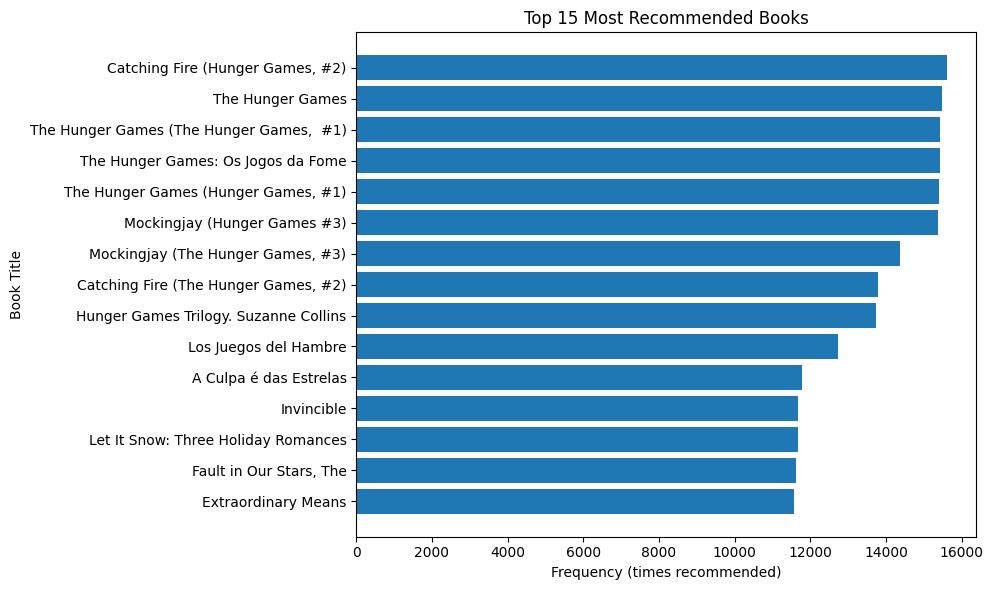

In [19]:
# 1. Flatten recommendations properly
flat_recs = test.select(pl.col("hnsw_multi_three").explode().alias("item_id"))

# 2. Count frequencies
freq_df = (
    flat_recs.group_by("item_id")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)

# 3. Join with book titles
top_10_df = (
    freq_df.head(15)
    .join(books.select(["item_id", "title"]), on="item_id", how="left")
)

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_10_df["title"].to_list()[::-1], top_10_df["count"].to_list()[::-1])
plt.xlabel("Frequency (times recommended)")
plt.ylabel("Book Title")
plt.title("Top 15 Most Recommended Books")
plt.tight_layout()
plt.show()


В топе опять экстра популярные айтемы. Все Голодные игры)

Также популярные испанские произведения. К счастью уже меньше серийных тайтлов где рандомно рекомендуется 3 или 4 серия книги. 

Но вот вездесущие Голодные игры исключение (похоже на мотоцикл Kawasaki который постоянно рекомендовался в приложении Т-банка)

/tmp/ipykernel_21539/4251111421.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


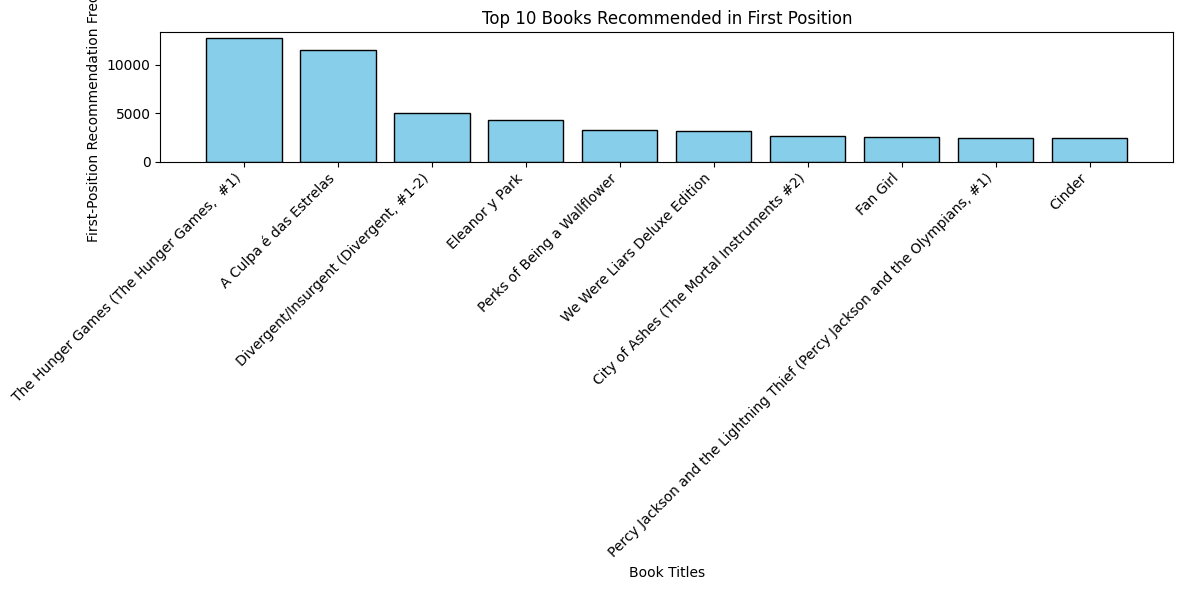

In [20]:
# Extract first-position recommendation directly in Polars
first_position_recs = test.select(
    pl.col("hnsw_multi_three").list.get(0).alias("item_id")
)

# Count frequency
freq_df = (
    first_position_recs.group_by("item_id")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)

# Join with books metadata
top_10_df = (
    freq_df.head(10)
    .join(books.select(["item_id", "title"]), on="item_id", how="left")
    .with_columns(pl.col("title").fill_null("Unknown Title"))
)

# Prepare data for plotting
titles = top_10_df["title"].to_list()
counts = top_10_df["count"].to_list()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(titles, counts, color="skyblue", edgecolor="black")
plt.xlabel("Book Titles")
plt.ylabel("First-Position Recommendation Frequency")
plt.title("Top 10 Books Recommended in First Position")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Здесь уже более разнообразные айтемы и нет какого то определенного айтема который вечно рекомендуется на 1м месте

### Сохраняем лучшую модель

In [21]:
import joblib
joblib.dump(item_hnsw_multi_three, "models/item_hnsw__three.joblib")

# Load
loaded_model = joblib.load("models/item_hnsw__three.joblib")

print(loaded_model.trained)


AttributeError: 'ItemHNSWMultiEmbedding' object has no attribute 'trained'